In [3]:
import re
import numpy as np
import pandas as pd

from sklearn.metrics import precision_recall_fscore_support, roc_auc_score, confusion_matrix

df = pd.read_csv("/content/drive/MyDrive/pca spam/emails.csv", encoding="utf-8", engine="python")
if '"spam"' in df.columns and "spam" not in df.columns:
    df = df.rename(columns={'"spam"': "spam"})

assert "text" in df.columns and "spam" in df.columns, f"Columns: {df.columns.tolist()}"

df["spam"] = df["spam"].astype(str).str.strip().astype(int)
df = df.sample(frac=1, random_state=42).reset_index(drop=True)

train_df = df.iloc[0:2000].copy()
val_df   = df.iloc[2000:3000].copy()
test_df  = df.iloc[3000:].copy()

y_train = train_df["spam"].to_numpy()
y_val   = val_df["spam"].to_numpy()
y_test  = test_df["spam"].to_numpy()

def clean_text(t: str) -> str:
    if pd.isna(t):
        return ""
    t = str(t).lower()
    t = re.sub(r"\bsubject\s*:\s*", " ", t)
    t = re.sub(r"http\S+|www\.\S+", " ", t)
    t = re.sub(r"\S+@\S+\.\S+", " ", t)
    t = re.sub(r"[^a-z\s]", " ", t)
    t = re.sub(r"\b[a-z]\b", " ", t)
    t = re.sub(r"\s+", " ", t).strip()
    return t

X_train_text = train_df["text"].astype(str).apply(clean_text).tolist()
X_val_text   = val_df["text"].astype(str).apply(clean_text).tolist()
X_test_text  = test_df["text"].astype(str).apply(clean_text).tolist()

def evaluate(y_true, y_pred, y_score=None, title="MODEL"):
    p, r, f1, _ = precision_recall_fscore_support(y_true, y_pred, average="binary", zero_division=0)

    auc = None
    if (y_score is not None) and (len(np.unique(y_true)) == 2):
        auc = roc_auc_score(y_true, y_score)

    cm = confusion_matrix(y_true, y_pred)

    print(f"\n=== {title} ===")
    if auc is None:
        print(f"Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f} | AUC: N/A")
    else:
        print(f"Precision: {p:.4f} | Recall: {r:.4f} | F1: {f1:.4f} | AUC: {auc:.4f}")
    print("Confusion Matrix [[TN FP],[FN TP]]:")
    print(cm)

    return {"precision": p, "recall": r, "f1": f1, "auc": auc, "cm": cm}

print("Sizes:", len(train_df), len(val_df), len(test_df))
print("Spam distribution (TRAIN):\n", train_df["spam"].value_counts())
print("Spam distribution (VAL):\n",   val_df["spam"].value_counts())
print("Spam distribution (TEST):\n",  test_df["spam"].value_counts())

Sizes: 2000 1000 2728
Spam distribution (TRAIN):
 spam
0    1487
1     513
Name: count, dtype: int64
Spam distribution (VAL):
 spam
0    780
1    220
Name: count, dtype: int64
Spam distribution (TEST):
 spam
0    2093
1     635
Name: count, dtype: int64


In [4]:
# Example
print("Example cleaned text (TRAIN):\n", X_train_text[0][:400])
print("Avg tokens train:", np.mean([len(x.split()) for x in X_train_text]))

Example cleaned text (TRAIN):
 re energy derivatives conference may toronto good morning amy vince kaminski will need the following an lcd projector to hook up to lap tap for his presentation he will have dinner with the conference organizers and speakers on the th he will need nights the th and the th hotel reservations he will send you an abstract shortly thanks and have great day shirley crenshaw amy aldous on am to shirley 
Avg tokens train: 213.423


In [5]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import f1_score
import numpy as np

alpha_grid = [0.1, 0.3, 0.5, 1.0]
ngram_grid = [(1, 1), (1, 2)]
min_df_grid = [1, 2, 5]
max_df = 0.95

best = {
    "val_f1": -1.0,
    "alpha": None,
    "ngram": None,
    "min_df": None,
    "tfidf": None,
    "nb": None
}

for alpha in alpha_grid:
    for ngram in ngram_grid:
        for min_df in min_df_grid:
            tfidf = TfidfVectorizer(
                ngram_range=ngram,
                min_df=min_df,
                max_df=max_df,
                stop_words="english"
            )

            Xtr = tfidf.fit_transform(X_train_text)
            Xva = tfidf.transform(X_val_text)

            nb = MultinomialNB(alpha=alpha)
            nb.fit(Xtr, y_train)

            va_pred = nb.predict(Xva)
            f1 = f1_score(y_val, va_pred)

            if f1 > best["val_f1"]:
                best.update({
                    "val_f1": f1,
                    "alpha": alpha,
                    "ngram": ngram,
                    "min_df": min_df,
                    "tfidf": tfidf,
                    "nb": nb
                })

print("Q2 BEST (by VAL F1):",
      "F1=", round(best["val_f1"], 4),
      "| alpha=", best["alpha"],
      "| ngram=", best["ngram"],
      "| min_df=", best["min_df"])

tfidf_best = best["tfidf"]
nb_best = best["nb"]

Xtr_tfidf = tfidf_best.transform(X_train_text)
Xva_tfidf = tfidf_best.transform(X_val_text)
Xte_tfidf = tfidf_best.transform(X_test_text)

q2_va_pred = nb_best.predict(Xva_tfidf)
q2_va_score = nb_best.predict_proba(Xva_tfidf)[:, 1]
q2_val = evaluate(y_val, q2_va_pred, q2_va_score, "Q2 Naive Bayes (TUNED) - VALIDATION")

q2_te_pred = nb_best.predict(Xte_tfidf)
q2_te_score = nb_best.predict_proba(Xte_tfidf)[:, 1]
q2_test = evaluate(y_test, q2_te_pred, q2_te_score, "Q2 Naive Bayes (TUNED) - TEST")

from sklearn.metrics import precision_recall_curve, f1_score

prec, rec, thr = precision_recall_curve(y_val, q2_va_score)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = int(np.argmax(f1s))
best_thr = thr[max(best_idx - 1, 0)] if len(thr) > 0 else 0.5

print("Q2 Best threshold (by VAL F1):", float(best_thr))
print("Q2 Best VAL F1 with threshold:", float(f1s[best_idx]))

q2_va_pred_thr = (q2_va_score >= best_thr).astype(int)
evaluate(y_val, q2_va_pred_thr, q2_va_score, f"Q2 NB (TUNED) - VALIDATION (thr={best_thr:.3f})")

q2_te_pred_thr = (q2_te_score >= best_thr).astype(int)
evaluate(y_test, q2_te_pred_thr, q2_te_score, f"Q2 NB (TUNED) - TEST (thr={best_thr:.3f})")

Q2 BEST (by VAL F1): F1= 0.9724 | alpha= 0.1 | ngram= (1, 1) | min_df= 5

=== Q2 Naive Bayes (TUNED) - VALIDATION ===
Precision: 0.9860 | Recall: 0.9591 | F1: 0.9724 | AUC: 0.9989
Confusion Matrix [[TN FP],[FN TP]]:
[[777   3]
 [  9 211]]

=== Q2 Naive Bayes (TUNED) - TEST ===
Precision: 0.9789 | Recall: 0.9480 | F1: 0.9632 | AUC: 0.9989
Confusion Matrix [[TN FP],[FN TP]]:
[[2080   13]
 [  33  602]]
Q2 Best threshold (by VAL F1): 0.3683360138819917
Q2 Best VAL F1 with threshold: 0.9748283752855411

=== Q2 NB (TUNED) - VALIDATION (thr=0.368) ===
Precision: 0.9771 | Recall: 0.9682 | F1: 0.9726 | AUC: 0.9989
Confusion Matrix [[TN FP],[FN TP]]:
[[775   5]
 [  7 213]]

=== Q2 NB (TUNED) - TEST (thr=0.368) ===
Precision: 0.9668 | Recall: 0.9638 | F1: 0.9653 | AUC: 0.9989
Confusion Matrix [[TN FP],[FN TP]]:
[[2072   21]
 [  23  612]]


{'precision': 0.966824644549763,
 'recall': 0.9637795275590552,
 'f1': 0.9652996845425867,
 'auc': np.float64(0.9989074944227289),
 'cm': array([[2072,   21],
        [  23,  612]])}

In [6]:
import numpy as np
from pathlib import Path
from sentence_transformers import SentenceTransformer

p_train = Path("E_train.npy")
p_val   = Path("E_val.npy")
p_test  = Path("E_test.npy")

if p_train.exists() and p_val.exists() and p_test.exists():
    E_train = np.load(p_train)
    E_val   = np.load(p_val)
    E_test  = np.load(p_test)
    print("Loaded embeddings from .npy")
else:
    st_model = SentenceTransformer("paraphrase-multilingual-MiniLM-L12-v2")
    E_train = st_model.encode(X_train_text, batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    E_val   = st_model.encode(X_val_text,   batch_size=64, show_progress_bar=True, normalize_embeddings=True)
    E_test  = st_model.encode(X_test_text,  batch_size=64, show_progress_bar=True, normalize_embeddings=True)

    np.save(p_train, E_train)
    np.save(p_val, E_val)
    np.save(p_test, E_test)
    print("Computed and saved embeddings to .npy")

print("Embeddings shapes:", E_train.shape, E_val.shape, E_test.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/229 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/122 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/645 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/471M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/480 [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/9.08M [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/32 [00:00<?, ?it/s]

Batches:   0%|          | 0/16 [00:00<?, ?it/s]

Batches:   0%|          | 0/43 [00:00<?, ?it/s]

Computed and saved embeddings to .npy
Embeddings shapes: (2000, 384) (1000, 384) (2728, 384)


In [7]:
import numpy as np
from sklearn.neighbors import KNeighborsClassifier

k_grid = [1, 3, 5, 7, 9, 11, 15, 21, 31]

q4_rows = []
best_k = None
best_f1 = -1
best_knn = None

for k in k_grid:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(E_train, y_train)

    va_pred = knn.predict(E_val)
    va_score = knn.predict_proba(E_val)[:, 1]
    res = evaluate(y_val, va_pred, va_score, f"Q4 kNN(k={k}) - VALIDATION")

    q4_rows.append((k, res["f1"], res["auc"]))
    if res["f1"] > best_f1:
        best_f1 = res["f1"]
        best_k = k
        best_knn = knn

print("\nBest k:", best_k, "val F1:", best_f1)

q4_te_pred = best_knn.predict(E_test)
q4_te_score = best_knn.predict_proba(E_test)[:, 1]
q4_test = evaluate(y_test, q4_te_pred, q4_te_score, f"Q4 kNN(k={best_k}) - TEST")


=== Q4 kNN(k=1) - VALIDATION ===
Precision: 0.9808 | Recall: 0.9273 | F1: 0.9533 | AUC: 0.9611
Confusion Matrix [[TN FP],[FN TP]]:
[[776   4]
 [ 16 204]]

=== Q4 kNN(k=3) - VALIDATION ===
Precision: 0.9804 | Recall: 0.9091 | F1: 0.9434 | AUC: 0.9794
Confusion Matrix [[TN FP],[FN TP]]:
[[776   4]
 [ 20 200]]

=== Q4 kNN(k=5) - VALIDATION ===
Precision: 0.9709 | Recall: 0.9091 | F1: 0.9390 | AUC: 0.9866
Confusion Matrix [[TN FP],[FN TP]]:
[[774   6]
 [ 20 200]]

=== Q4 kNN(k=7) - VALIDATION ===
Precision: 0.9561 | Recall: 0.8909 | F1: 0.9224 | AUC: 0.9902
Confusion Matrix [[TN FP],[FN TP]]:
[[771   9]
 [ 24 196]]

=== Q4 kNN(k=9) - VALIDATION ===
Precision: 0.9655 | Recall: 0.8909 | F1: 0.9267 | AUC: 0.9899
Confusion Matrix [[TN FP],[FN TP]]:
[[773   7]
 [ 24 196]]

=== Q4 kNN(k=11) - VALIDATION ===
Precision: 0.9610 | Recall: 0.8955 | F1: 0.9271 | AUC: 0.9897
Confusion Matrix [[TN FP],[FN TP]]:
[[772   8]
 [ 23 197]]

=== Q4 kNN(k=15) - VALIDATION ===
Precision: 0.9604 | Recall: 0.8818

In [8]:
import numpy as np
from sklearn.svm import SVC

svm_candidates = {
    "linear": SVC(kernel="linear", C=1.0),
    "poly":   SVC(kernel="poly", degree=3, C=1.0, gamma="scale", coef0=0.0),
    "rbf":    SVC(kernel="rbf", C=1.0, gamma="scale"),
}

q5_rows = []
best_kernel = None
best_f1 = -1
best_svm = None

for name, svm in svm_candidates.items():
    svm.fit(E_train, y_train)

    va_pred = svm.predict(E_val)
    va_score = svm.decision_function(E_val)
    res = evaluate(y_val, va_pred, va_score, f"Q5 SVM({name}) - VALIDATION")

    q5_rows.append((name, res["f1"], res["auc"]))
    if res["f1"] > best_f1:
        best_f1 = res["f1"]
        best_kernel = name
        best_svm = svm

print("\nBest kernel:", best_kernel, "val F1:", best_f1)

q5_te_pred = best_svm.predict(E_test)
q5_te_score = best_svm.decision_function(E_test)
q5_test = evaluate(y_test, q5_te_pred, q5_te_score, f"Q5 SVM({best_kernel}) - TEST")


=== Q5 SVM(linear) - VALIDATION ===
Precision: 0.9238 | Recall: 0.9364 | F1: 0.9300 | AUC: 0.9930
Confusion Matrix [[TN FP],[FN TP]]:
[[763  17]
 [ 14 206]]

=== Q5 SVM(poly) - VALIDATION ===
Precision: 0.9721 | Recall: 0.9500 | F1: 0.9609 | AUC: 0.9965
Confusion Matrix [[TN FP],[FN TP]]:
[[774   6]
 [ 11 209]]

=== Q5 SVM(rbf) - VALIDATION ===
Precision: 0.9378 | Recall: 0.9591 | F1: 0.9483 | AUC: 0.9960
Confusion Matrix [[TN FP],[FN TP]]:
[[766  14]
 [  9 211]]

Best kernel: poly val F1: 0.960919540229885

=== Q5 SVM(poly) - TEST ===
Precision: 0.9788 | Recall: 0.9433 | F1: 0.9607 | AUC: 0.9982
Confusion Matrix [[TN FP],[FN TP]]:
[[2080   13]
 [  36  599]]


In [9]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC

def make_svm(kernel_name: str):
    if kernel_name == "linear":
        return SVC(kernel="linear", C=1.0)
    if kernel_name == "poly":
        return SVC(kernel="poly", degree=3, C=1.0, gamma="scale", coef0=0.0)
    return SVC(kernel="rbf", C=1.0, gamma="scale")

vars_ = [0.90, 0.95, 0.99]
q6_rows = []

best_var = None
best_f1 = -1
best_pipe = None

for v in vars_:
    pipe = Pipeline(steps=[
        ("scaler", StandardScaler()),
        ("pca", PCA(n_components=v, random_state=42)),
        ("svm", make_svm(best_kernel)),
    ])
    pipe.fit(E_train, y_train)

    va_pred = pipe.predict(E_val)
    va_score = pipe.decision_function(E_val)
    res = evaluate(y_val, va_pred, va_score, f"Q6 PCA({int(v*100)}%)+SVM({best_kernel}) - VALIDATION")

    n_comp = pipe.named_steps["pca"].n_components_
    q6_rows.append((v, n_comp, res["f1"], res["auc"]))

    if res["f1"] > best_f1:
        best_f1 = res["f1"]
        best_var = v
        best_pipe = pipe

print("\nBest PCA variance:", int(best_var*100), "%", "val F1:", best_f1)

q6_te_pred = best_pipe.predict(E_test)
q6_te_score = best_pipe.decision_function(E_test)
q6_test = evaluate(y_test, q6_te_pred, q6_te_score, f"Q6 PCA({int(best_var*100)}%)+SVM({best_kernel}) - TEST")


=== Q6 PCA(90%)+SVM(poly) - VALIDATION ===
Precision: 0.9949 | Recall: 0.8955 | F1: 0.9426 | AUC: 0.9967
Confusion Matrix [[TN FP],[FN TP]]:
[[779   1]
 [ 23 197]]

=== Q6 PCA(95%)+SVM(poly) - VALIDATION ===
Precision: 0.9949 | Recall: 0.8818 | F1: 0.9349 | AUC: 0.9967
Confusion Matrix [[TN FP],[FN TP]]:
[[779   1]
 [ 26 194]]

=== Q6 PCA(99%)+SVM(poly) - VALIDATION ===
Precision: 0.9948 | Recall: 0.8682 | F1: 0.9272 | AUC: 0.9967
Confusion Matrix [[TN FP],[FN TP]]:
[[779   1]
 [ 29 191]]

Best PCA variance: 90 % val F1: 0.9425837320574163

=== Q6 PCA(90%)+SVM(poly) - TEST ===
Precision: 0.9927 | Recall: 0.8567 | F1: 0.9197 | AUC: 0.9978
Confusion Matrix [[TN FP],[FN TP]]:
[[2089    4]
 [  91  544]]


In [10]:
import numpy as np
from sklearn.decomposition import PCA
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

components_grid = [10, 20, 50, 100, 200]
C_grid = [0.01, 0.1, 1, 10, 100]

best = {
    "val_f1": -1.0,
    "n_components": None,
    "C": None,
    "pipe": None
}

for n_comp in components_grid:
    for C in C_grid:
        pipe = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=n_comp, random_state=42)),
            ("lr", LogisticRegression(max_iter=5000, C=C))
        ])
        pipe.fit(E_train, y_train)

        va_pred = pipe.predict(E_val)
        f1 = f1_score(y_val, va_pred)

        if f1 > best["val_f1"]:
            best.update({
                "val_f1": f1,
                "n_components": n_comp,
                "C": C,
                "pipe": pipe
            })

print("Q7 BEST (by VAL F1):",
      "F1=", round(best["val_f1"], 4),
      "| PCA components=", best["n_components"],
      "| C=", best["C"])

q7_pipe = best["pipe"]
q7_va_pred = q7_pipe.predict(E_val)
q7_va_score = q7_pipe.predict_proba(E_val)[:, 1]
q7_val = evaluate(y_val, q7_va_pred, q7_va_score, f"Q7 PCA({best['n_components']})+LogReg(C={best['C']}) - VALIDATION")

q7_te_pred = q7_pipe.predict(E_test)
q7_te_score = q7_pipe.predict_proba(E_test)[:, 1]
q7_test = evaluate(y_test, q7_te_pred, q7_te_score, f"Q7 PCA({best['n_components']})+LogReg(C={best['C']}) - TEST")

from sklearn.metrics import precision_recall_curve

prec, rec, thr = precision_recall_curve(y_val, q7_va_score)
f1s = 2 * (prec * rec) / (prec + rec + 1e-12)

best_idx = int(np.argmax(f1s))
best_thr = thr[max(best_idx - 1, 0)] if len(thr) > 0 else 0.5

print("Q7 Best threshold (by VAL F1):", float(best_thr))
print("Q7 Best VAL F1 with threshold:", float(f1s[best_idx]))

q7_va_pred_thr = (q7_va_score >= best_thr).astype(int)
evaluate(y_val, q7_va_pred_thr, q7_va_score, f"Q7 (TUNED) - VALIDATION (thr={best_thr:.3f})")

q7_te_pred_thr = (q7_te_score >= best_thr).astype(int)
evaluate(y_test, q7_te_pred_thr, q7_te_score, f"Q7 (TUNED) - TEST (thr={best_thr:.3f})")

Q7 BEST (by VAL F1): F1= 0.9258 | PCA components= 200 | C= 0.01

=== Q7 PCA(200)+LogReg(C=0.01) - VALIDATION ===
Precision: 0.9156 | Recall: 0.9364 | F1: 0.9258 | AUC: 0.9927
Confusion Matrix [[TN FP],[FN TP]]:
[[761  19]
 [ 14 206]]

=== Q7 PCA(200)+LogReg(C=0.01) - TEST ===
Precision: 0.9354 | Recall: 0.9354 | F1: 0.9354 | AUC: 0.9953
Confusion Matrix [[TN FP],[FN TP]]:
[[2052   41]
 [  41  594]]
Q7 Best threshold (by VAL F1): 0.4643846829290436
Q7 Best VAL F1 with threshold: 0.9330357142852143

=== Q7 (TUNED) - VALIDATION (thr=0.464) ===
Precision: 0.9127 | Recall: 0.9500 | F1: 0.9310 | AUC: 0.9927
Confusion Matrix [[TN FP],[FN TP]]:
[[760  20]
 [ 11 209]]

=== Q7 (TUNED) - TEST (thr=0.464) ===
Precision: 0.9346 | Recall: 0.9449 | F1: 0.9397 | AUC: 0.9953
Confusion Matrix [[TN FP],[FN TP]]:
[[2051   42]
 [  35  600]]


{'precision': 0.9345794392523364,
 'recall': 0.9448818897637795,
 'f1': 0.9397024275646045,
 'auc': np.float64(0.9953267547242213),
 'cm': array([[2051,   42],
        [  35,  600]])}

In [11]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, precision_recall_curve, average_precision_score, roc_auc_score

def plot_confusion(cm, title):
    fig, ax = plt.subplots()
    ax.imshow(cm)
    ax.set_title(title)
    ax.set_xlabel("Predicted")
    ax.set_ylabel("True")
    ax.set_xticks([0,1]); ax.set_yticks([0,1])
    ax.set_xticklabels(["0","1"]); ax.set_yticklabels(["0","1"])
    for (i,j), v in np.ndenumerate(cm):
        ax.text(j, i, str(v), ha="center", va="center")
    plt.tight_layout()
    plt.show()

def plot_roc(y_true, y_score, title):
    if len(np.unique(y_true)) < 2:
        print(f"{title}: ROC not defined (single class).")
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    fig, ax = plt.subplots()
    ax.plot(fpr, tpr)
    ax.plot([0,1],[0,1], linestyle="--")
    ax.set_title(f"{title} (AUC={auc:.4f})")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    plt.tight_layout()
    plt.show()

def plot_pr(y_true, y_score, title):
    if len(np.unique(y_true)) < 2:
        print(f"{title}: PR not defined (single class).")
        return
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    fig, ax = plt.subplots()
    ax.plot(rec, prec)
    ax.set_title(f"{title} (AP={ap:.4f})")
    ax.set_xlabel("Recall")
    ax.set_ylabel("Precision")
    plt.tight_layout()
    plt.show()


TRAIN Set:
Class 0: 1487 samples (34.11% of class 0)
Class 1: 513 samples (37.50% of class 1)

VAL Set:
Class 0: 780 samples (17.89% of class 0)
Class 1: 220 samples (16.08% of class 1)

TEST Set:
Class 0: 2093 samples (48.00% of class 0)
Class 1: 635 samples (46.42% of class 1)


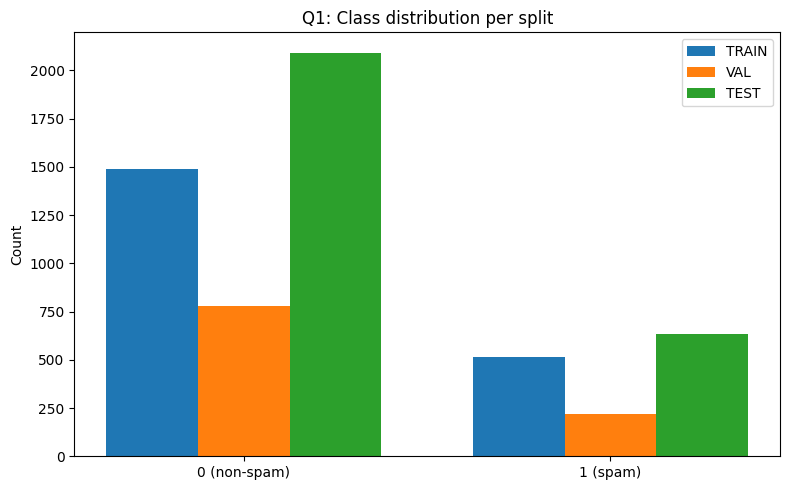

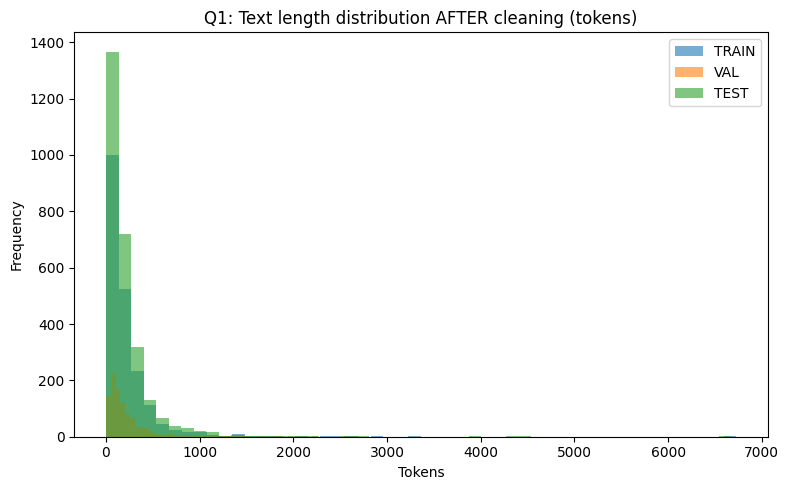

In [12]:
import numpy as np
import matplotlib.pyplot as plt

def plot_class_counts_and_percentages():
    splits = {
        "TRAIN": y_train,
        "VAL":   y_val,
        "TEST":  y_test
    }
    total_counts = {c: int((df["spam"] == c).sum()) for c in [0,1]}

    for name, y_ in splits.items():
        unique, counts = np.unique(y_, return_counts=True)
        print(f"\n{name} Set:")
        for cls, cnt in zip(unique, counts):
            pct = 100.0 * cnt / total_counts[int(cls)] if total_counts[int(cls)] > 0 else 0.0
            print(f"Class {cls}: {cnt} samples ({pct:.2f}% of class {cls})")

    # bar plot counts
    train_counts = [(y_train == 0).sum(), (y_train == 1).sum()]
    val_counts   = [(y_val == 0).sum(),   (y_val == 1).sum()]
    test_counts  = [(y_test == 0).sum(),  (y_test == 1).sum()]

    x = np.arange(2)
    width = 0.25

    plt.figure(figsize=(8,5))
    plt.bar(x - width, train_counts, width, label="TRAIN")
    plt.bar(x,         val_counts,   width, label="VAL")
    plt.bar(x + width, test_counts,  width, label="TEST")
    plt.xticks(x, ["0 (non-spam)", "1 (spam)"])
    plt.title("Q1: Class distribution per split")
    plt.ylabel("Count")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_class_counts_and_percentages()

train_len = [len(x.split()) for x in X_train_text]
val_len   = [len(x.split()) for x in X_val_text]
test_len  = [len(x.split()) for x in X_test_text]

plt.figure(figsize=(8,5))
plt.hist(train_len, bins=50, alpha=0.6, label="TRAIN")
plt.hist(val_len,   bins=50, alpha=0.6, label="VAL")
plt.hist(test_len,  bins=50, alpha=0.6, label="TEST")
plt.title("Q1: Text length distribution AFTER cleaning (tokens)")
plt.xlabel("Tokens")
plt.ylabel("Frequency")
plt.legend()
plt.tight_layout()
plt.show()

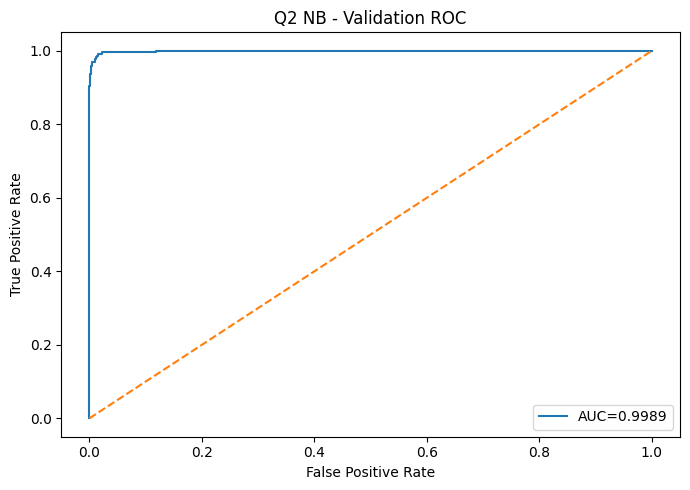

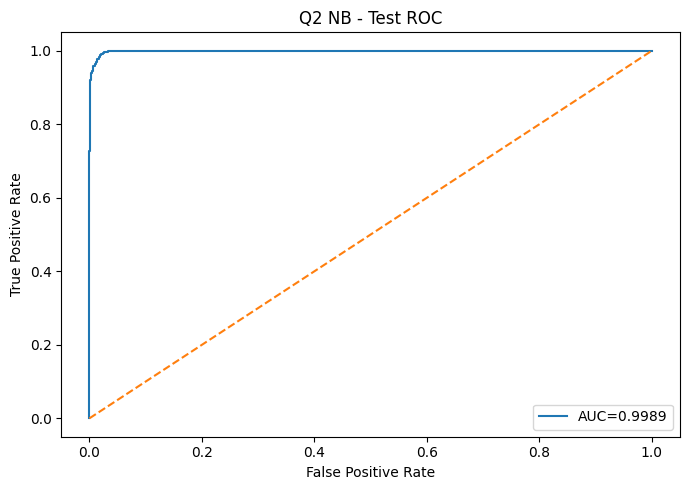

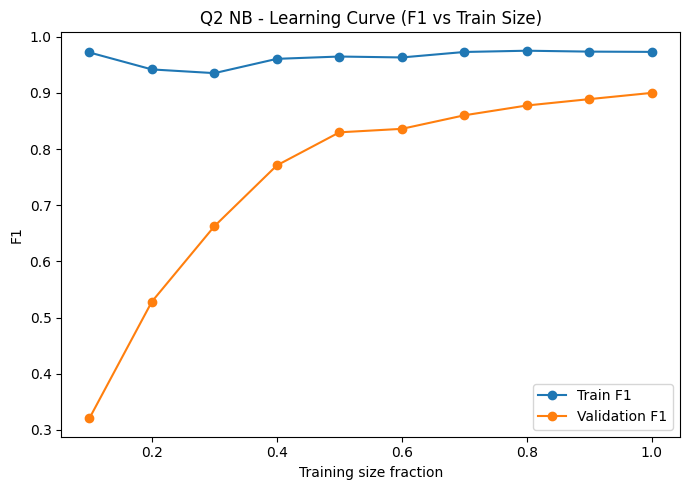

In [13]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, roc_auc_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

def plot_roc_curve(y_true, y_score, title):
    if len(np.unique(y_true)) < 2:
        print(f"{title}: ROC not defined (single class).")
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1], [0,1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc_curve(y_val,  q2_va_score, "Q2 NB - Validation ROC")
plot_roc_curve(y_test, q2_te_score, "Q2 NB - Test ROC")

def generate_learning_curve_nb(X_train_text, y_train, X_val_text, y_val):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_f1_scores = []
    val_f1_scores = []

    tfidf = TfidfVectorizer(ngram_range=(1,2), min_df=2, max_df=0.95, stop_words="english")
    Xtr_full = tfidf.fit_transform(X_train_text)
    Xva = tfidf.transform(X_val_text)

    for ts in train_sizes:
        n = max(1, int(ts * Xtr_full.shape[0]))
        Xtr = Xtr_full[:n]
        ytr = y_train[:n]

        nb = MultinomialNB(alpha=0.5)
        nb.fit(Xtr, ytr)

        ytr_pred = nb.predict(Xtr)
        yva_pred = nb.predict(Xva)

        train_f1_scores.append(f1_score(ytr, ytr_pred))
        val_f1_scores.append(f1_score(y_val, yva_pred))

    return train_sizes, train_f1_scores, val_f1_scores

sizes, f1_tr, f1_va = generate_learning_curve_nb(X_train_text, y_train, X_val_text, y_val)

plt.figure(figsize=(7,5))
plt.plot(sizes, f1_tr, marker="o", label="Train F1")
plt.plot(sizes, f1_va, marker="o", label="Validation F1")
plt.title("Q2 NB - Learning Curve (F1 vs Train Size)")
plt.xlabel("Training size fraction")
plt.ylabel("F1")
plt.legend()
plt.tight_layout()
plt.show()


PCA explained variance ratio: [0.0736687 0.0438407]


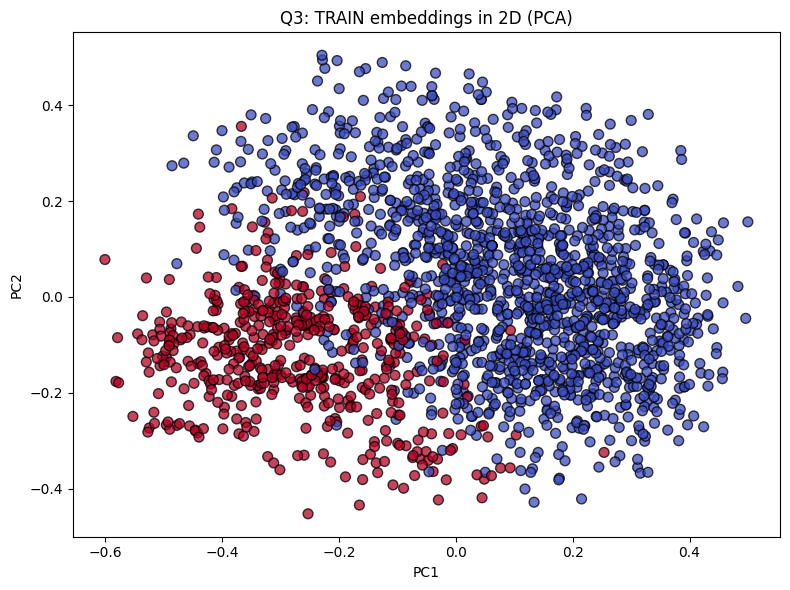

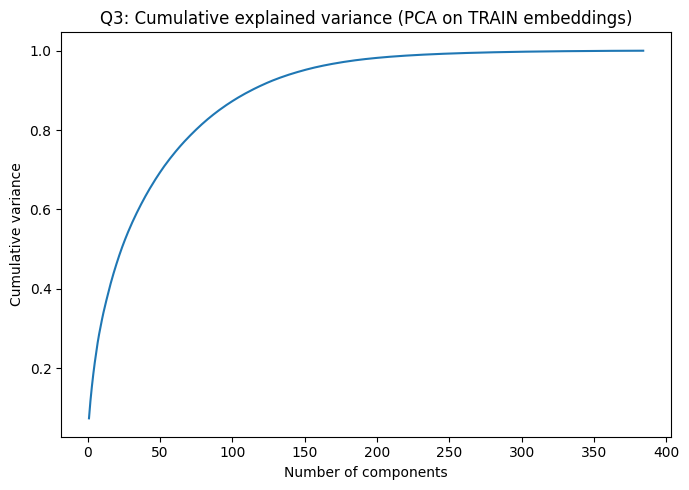

In [14]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca = PCA(n_components=2, random_state=42)
Z = pca.fit_transform(E_train)

print("\nPCA explained variance ratio:", pca.explained_variance_ratio_)

Z_df = pd.DataFrame(Z, columns=["PC1", "PC2"])

plt.figure(figsize=(8,6))
plt.scatter(Z_df["PC1"], Z_df["PC2"], c=y_train, edgecolors="k", s=50, cmap=plt.cm.coolwarm, alpha=0.75)
plt.title("Q3: TRAIN embeddings in 2D (PCA)")
plt.xlabel("PC1")
plt.ylabel("PC2")
plt.tight_layout()
plt.show()

pca_full = PCA(random_state=42).fit(E_train)
cum = np.cumsum(pca_full.explained_variance_ratio_)
plt.figure(figsize=(7,5))
plt.plot(np.arange(1, len(cum)+1), cum)
plt.title("Q3: Cumulative explained variance (PCA on TRAIN embeddings)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.tight_layout()
plt.show()

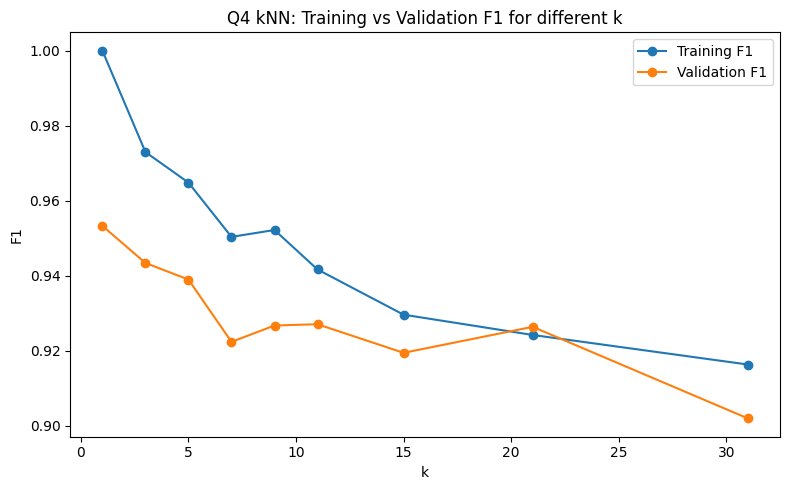

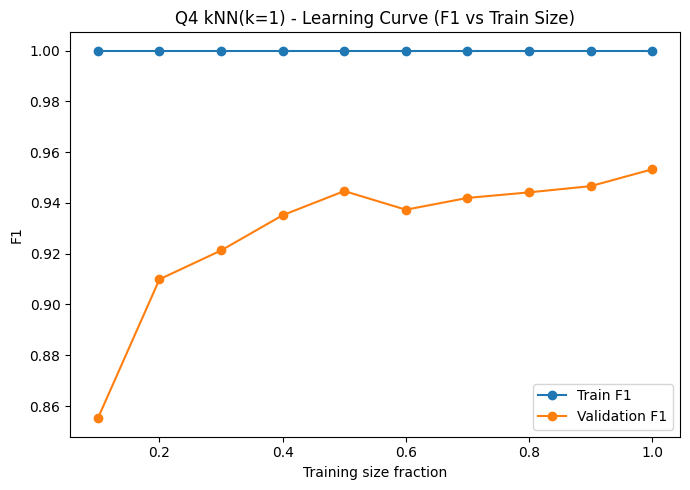

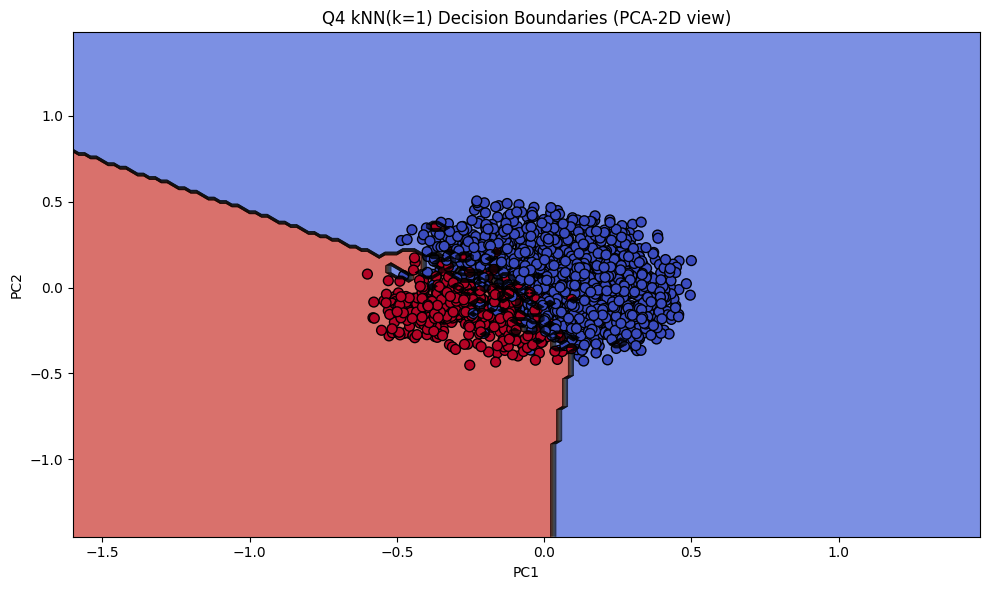

In [15]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

k_values = [r[0] for r in q4_rows]

train_f1s = []
val_f1s   = []

for k in k_values:
    knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
    knn.fit(E_train, y_train)

    ytr_pred = knn.predict(E_train)
    yva_pred = knn.predict(E_val)

    train_f1s.append(f1_score(y_train, ytr_pred))
    val_f1s.append(f1_score(y_val, yva_pred))

plt.figure(figsize=(8,5))
plt.plot(k_values, train_f1s, marker="o", label="Training F1")
plt.plot(k_values, val_f1s,   marker="o", label="Validation F1")
plt.title("Q4 kNN: Training vs Validation F1 for different k")
plt.xlabel("k")
plt.ylabel("F1")
plt.legend()
plt.tight_layout()
plt.show()

def generate_learning_curve_knn(E_train, y_train, E_val, y_val, k):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_f1_scores = []
    val_f1_scores = []

    for ts in train_sizes:
        n = max(1, int(ts * len(E_train)))
        Xtr = E_train[:n]
        ytr = y_train[:n]

        knn = KNeighborsClassifier(n_neighbors=k, metric="cosine")
        knn.fit(Xtr, ytr)

        ytr_pred = knn.predict(Xtr)
        yva_pred = knn.predict(E_val)

        train_f1_scores.append(f1_score(ytr, ytr_pred))
        val_f1_scores.append(f1_score(y_val, yva_pred))

    return train_sizes, train_f1_scores, val_f1_scores

sizes, f1_tr, f1_va = generate_learning_curve_knn(E_train, y_train, E_val, y_val, best_k)

plt.figure(figsize=(7,5))
plt.plot(sizes, f1_tr, marker="o", label="Train F1")
plt.plot(sizes, f1_va, marker="o", label="Validation F1")
plt.title(f"Q4 kNN(k={best_k}) - Learning Curve (F1 vs Train Size)")
plt.xlabel("Training size fraction")
plt.ylabel("F1")
plt.legend()
plt.tight_layout()
plt.show()

pca2 = PCA(n_components=2, random_state=42)
E2 = pca2.fit_transform(E_train)

knn2d = KNeighborsClassifier(n_neighbors=best_k)
knn2d.fit(E2, y_train)

def plot_knn_decision_boundaries(X2, y, model, title):
    h = 0.02
    x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
    y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = model.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(10,6))
    plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm)
    plt.contour(xx, yy, Z, colors="black", linewidths=0.5)
    plt.scatter(X2[:, 0], X2[:, 1], c=y, edgecolors="k", marker="o", s=50, cmap=plt.cm.coolwarm)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

plot_knn_decision_boundaries(E2, y_train, knn2d, f"Q4 kNN(k={best_k}) Decision Boundaries (PCA-2D view)")

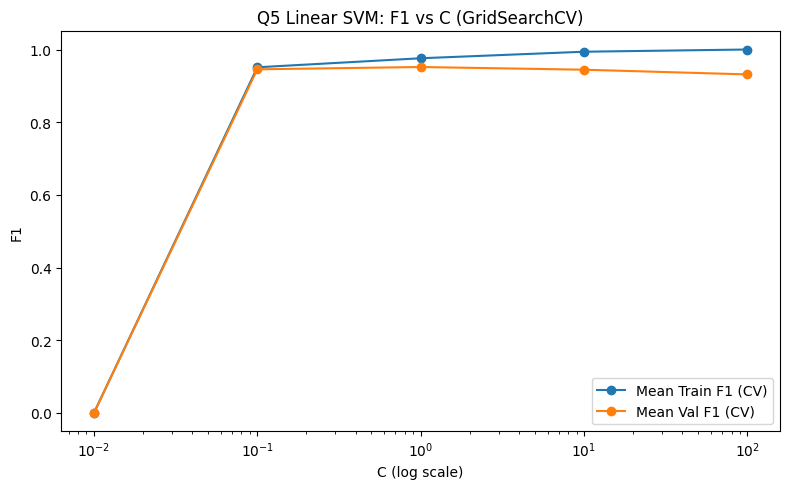

Best Linear SVM C: 1


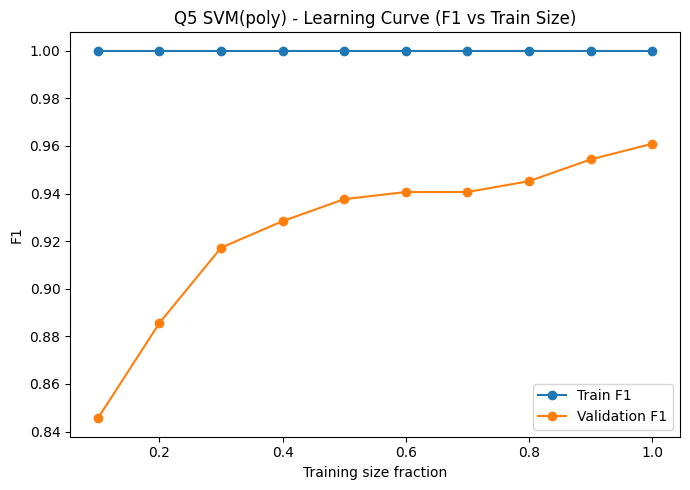

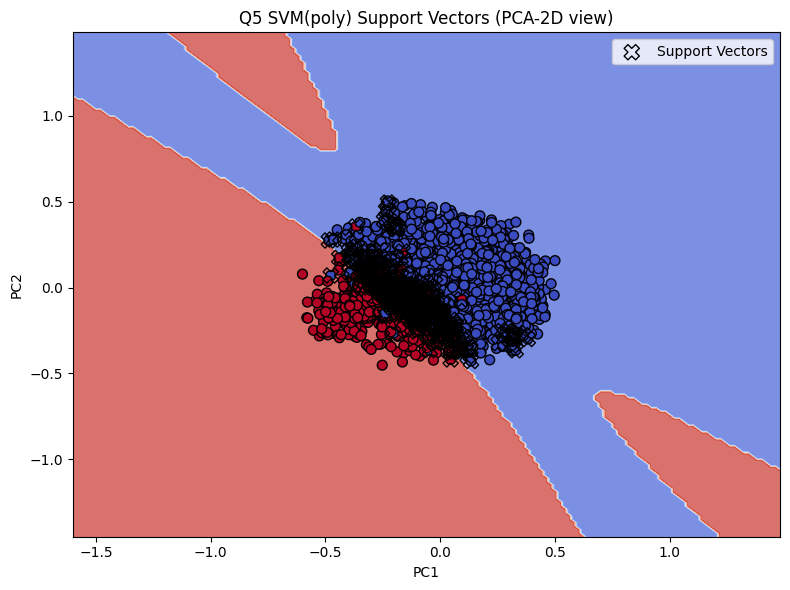

In [16]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import f1_score
from sklearn.decomposition import PCA

C_values = [0.01, 0.1, 1, 10, 100]
param_grid = {"C": C_values}

grid = GridSearchCV(
    SVC(kernel="linear"),
    param_grid=param_grid,
    cv=5,
    scoring="f1",
    return_train_score=True
)
grid.fit(E_train, y_train)

results = grid.cv_results_
mean_train = results["mean_train_score"]
mean_val   = results["mean_test_score"]

plt.figure(figsize=(8,5))
plt.semilogx(C_values, mean_train, marker="o", label="Mean Train F1 (CV)")
plt.semilogx(C_values, mean_val,   marker="o", label="Mean Val F1 (CV)")
plt.title("Q5 Linear SVM: F1 vs C (GridSearchCV)")
plt.xlabel("C (log scale)")
plt.ylabel("F1")
plt.legend()
plt.tight_layout()
plt.show()

print("Best Linear SVM C:", grid.best_params_["C"])

def generate_learning_curve_svm(E_train, y_train, E_val, y_val, kernel, C=1.0, gamma="scale"):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_f1_scores = []
    val_f1_scores = []

    for ts in train_sizes:
        n = max(1, int(ts * len(E_train)))
        Xtr = E_train[:n]
        ytr = y_train[:n]

        svm = SVC(kernel=kernel, C=C, gamma=gamma)
        svm.fit(Xtr, ytr)

        ytr_pred = svm.predict(Xtr)
        yva_pred = svm.predict(E_val)

        train_f1_scores.append(f1_score(ytr, ytr_pred))
        val_f1_scores.append(f1_score(y_val, yva_pred))

    return train_sizes, train_f1_scores, val_f1_scores

kernel = best_kernel
C_used = 1.0
gamma_used = "scale"

sizes, f1_tr, f1_va = generate_learning_curve_svm(E_train, y_train, E_val, y_val, kernel, C=C_used, gamma=gamma_used)

plt.figure(figsize=(7,5))
plt.plot(sizes, f1_tr, marker="o", label="Train F1")
plt.plot(sizes, f1_va, marker="o", label="Validation F1")
plt.title(f"Q5 SVM({best_kernel}) - Learning Curve (F1 vs Train Size)")
plt.xlabel("Training size fraction")
plt.ylabel("F1")
plt.legend()
plt.tight_layout()
plt.show()

pca2 = PCA(n_components=2, random_state=42)
E2 = pca2.fit_transform(E_train)

svm2d = SVC(kernel=best_kernel, C=1.0, gamma="scale")
svm2d.fit(E2, y_train)

def plot_support_vectors_2d(X2, y, svm, title):
    h = 0.02
    x_min, x_max = X2[:, 0].min() - 1, X2[:, 0].max() + 1
    y_min, y_max = X2[:, 1].min() - 1, X2[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = svm.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(8,6))
    plt.contourf(xx, yy, Z, alpha=0.75, cmap=plt.cm.coolwarm)

    plt.scatter(X2[:, 0], X2[:, 1], c=y, edgecolors="k", marker="o", s=50, cmap=plt.cm.coolwarm)
    if hasattr(svm, "support_vectors_"):
        sv = svm.support_vectors_
        plt.scatter(sv[:, 0], sv[:, 1], facecolors="none", edgecolors="black", s=120, marker="X", label="Support Vectors")
        plt.legend()

    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

plot_support_vectors_2d(E2, y_train, svm2d, f"Q5 SVM({best_kernel}) Support Vectors (PCA-2D view)")

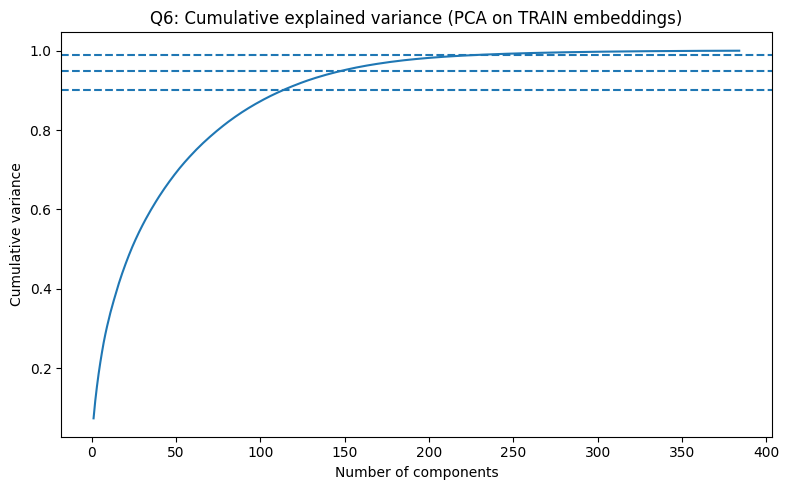

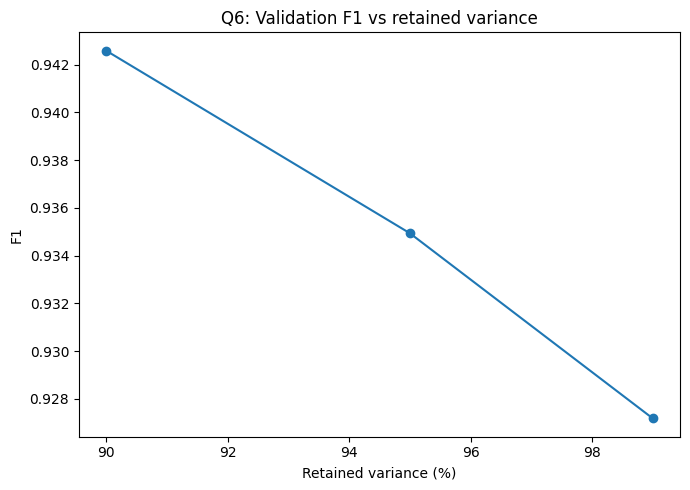

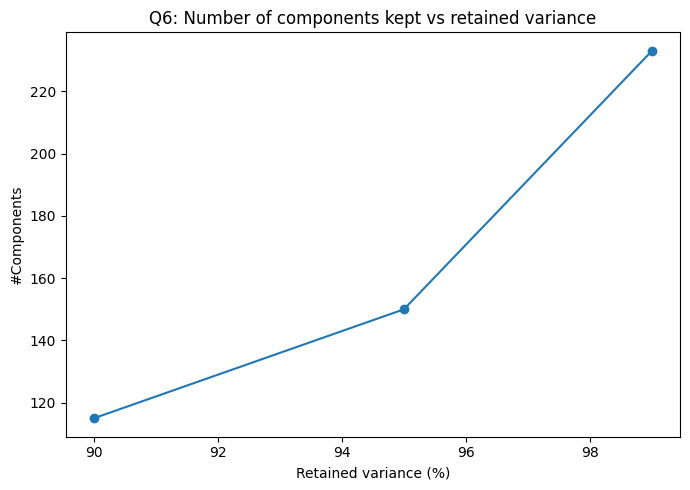

In [17]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

pca_full = PCA(random_state=42).fit(E_train)
cum_var = np.cumsum(pca_full.explained_variance_ratio_)

plt.figure(figsize=(8,5))
plt.plot(np.arange(1, len(cum_var)+1), cum_var)
plt.axhline(0.90, linestyle="--")
plt.axhline(0.95, linestyle="--")
plt.axhline(0.99, linestyle="--")
plt.title("Q6: Cumulative explained variance (PCA on TRAIN embeddings)")
plt.xlabel("Number of components")
plt.ylabel("Cumulative variance")
plt.tight_layout()
plt.show()

vars_pct = [int(v*100) for (v, ncomp, f1, auc) in q6_rows]
f1s      = [f1 for (v, ncomp, f1, auc) in q6_rows]

plt.figure(figsize=(7,5))
plt.plot(vars_pct, f1s, marker="o")
plt.title("Q6: Validation F1 vs retained variance")
plt.xlabel("Retained variance (%)")
plt.ylabel("F1")
plt.tight_layout()
plt.show()

comps = [ncomp for (v, ncomp, f1, auc) in q6_rows]

plt.figure(figsize=(7,5))
plt.plot(vars_pct, comps, marker="o")
plt.title("Q6: Number of components kept vs retained variance")
plt.xlabel("Retained variance (%)")
plt.ylabel("#Components")
plt.tight_layout()
plt.show()

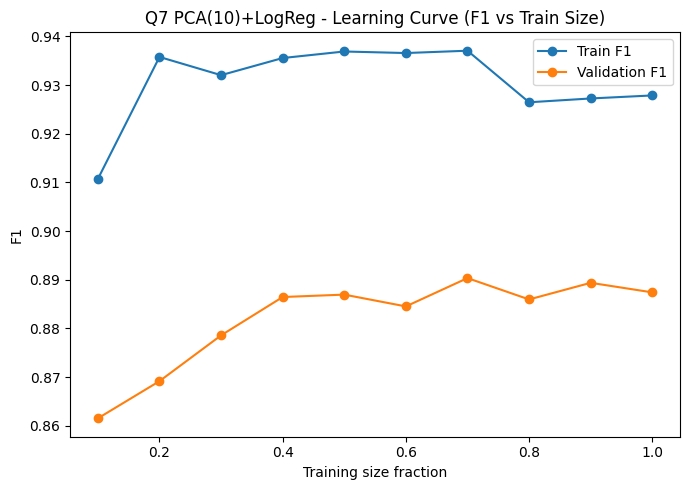

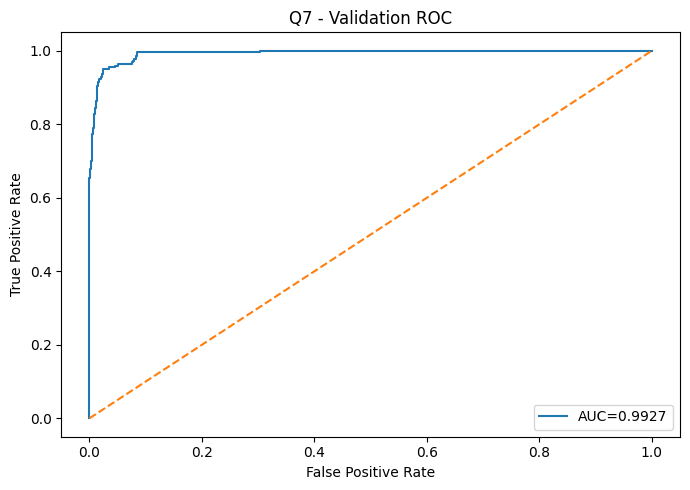

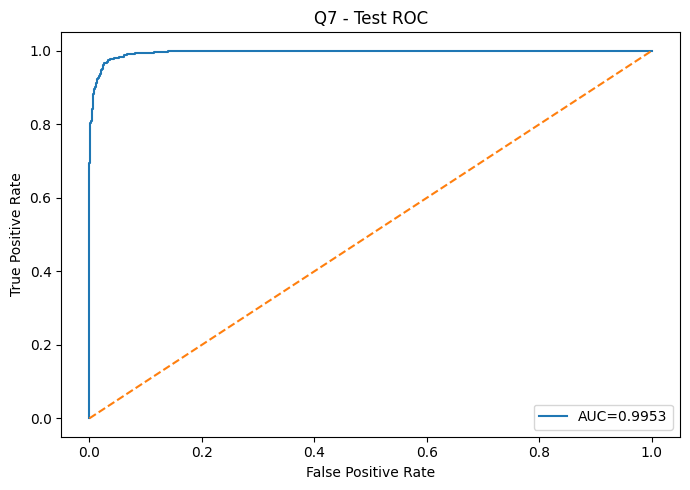

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, roc_curve, roc_auc_score

def generate_learning_curve_lr(E_train, y_train, E_val, y_val):
    train_sizes = np.linspace(0.1, 1.0, 10)
    train_f1_scores = []
    val_f1_scores = []

    for ts in train_sizes:
        n = max(1, int(ts * len(E_train)))
        Xtr = E_train[:n]
        ytr = y_train[:n]

        pipe = Pipeline(steps=[
            ("scaler", StandardScaler()),
            ("pca", PCA(n_components=10, random_state=42)),
            ("lr", LogisticRegression(max_iter=3000))
        ])
        pipe.fit(Xtr, ytr)

        ytr_pred = pipe.predict(Xtr)
        yva_pred = pipe.predict(E_val)

        train_f1_scores.append(f1_score(ytr, ytr_pred))
        val_f1_scores.append(f1_score(y_val, yva_pred))

    return train_sizes, train_f1_scores, val_f1_scores

sizes, f1_tr, f1_va = generate_learning_curve_lr(E_train, y_train, E_val, y_val)

plt.figure(figsize=(7,5))
plt.plot(sizes, f1_tr, marker="o", label="Train F1")
plt.plot(sizes, f1_va, marker="o", label="Validation F1")
plt.title("Q7 PCA(10)+LogReg - Learning Curve (F1 vs Train Size)")
plt.xlabel("Training size fraction")
plt.ylabel("F1")
plt.legend()
plt.tight_layout()
plt.show()

def plot_roc(y_true, y_score, title):
    if len(np.unique(y_true)) < 2:
        print(f"{title}: ROC not defined (single class).")
        return
    fpr, tpr, _ = roc_curve(y_true, y_score)
    auc = roc_auc_score(y_true, y_score)
    plt.figure(figsize=(7,5))
    plt.plot(fpr, tpr, label=f"AUC={auc:.4f}")
    plt.plot([0,1],[0,1], linestyle="--")
    plt.title(title)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.legend()
    plt.tight_layout()
    plt.show()

plot_roc(y_val,  q7_va_score, "Q7 - Validation ROC")
plot_roc(y_test, q7_te_score, "Q7 - Test ROC")

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import precision_recall_curve, average_precision_score

def plot_pr_curve(y_true, y_score, title):
    if len(np.unique(y_true)) < 2:
        print(f"{title}: PR not defined (single class).")
        return
    prec, rec, _ = precision_recall_curve(y_true, y_score)
    ap = average_precision_score(y_true, y_score)
    plt.figure(figsize=(7,5))
    plt.plot(rec, prec, label=f"AP={ap:.4f}")
    plt.title(title)
    plt.xlabel("Recall")
    plt.ylabel("Precision")
    plt.legend()
    plt.tight_layout()
    plt.show()

def plot_score_hist(y_true, y_score, title):
    plt.figure(figsize=(7,5))
    plt.hist(y_score[y_true==0], bins=40, alpha=0.7, label="y=0 (non-spam)")
    plt.hist(y_score[y_true==1], bins=40, alpha=0.7, label="y=1 (spam)")
    plt.title(title)
    plt.xlabel("Score / Probability for class=1")
    plt.ylabel("Frequency")
    plt.legend()
    plt.tight_layout()
    plt.show()

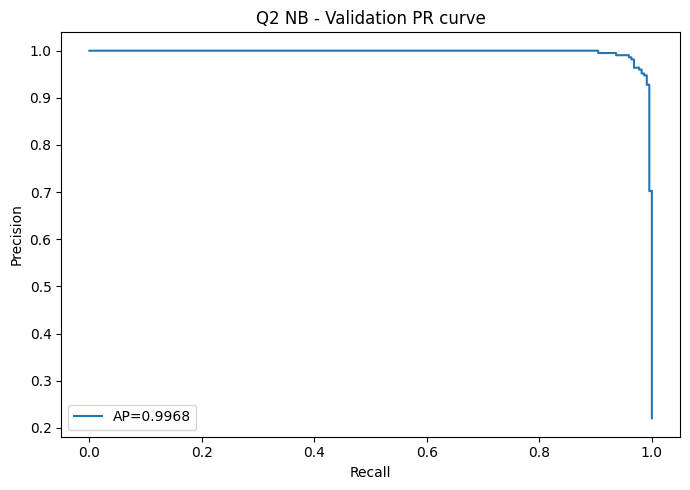

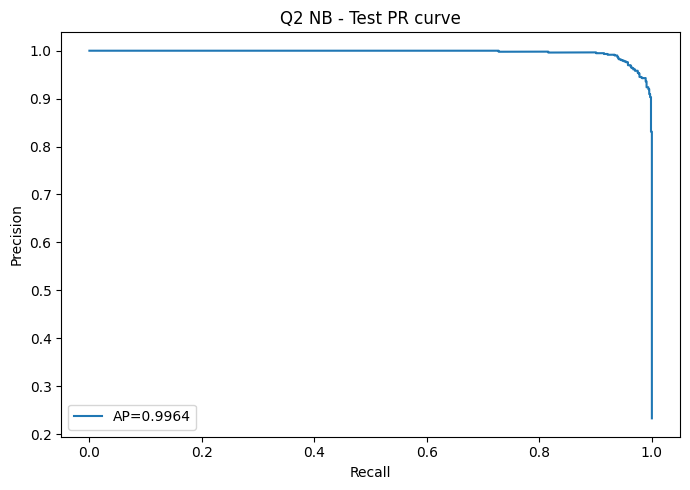

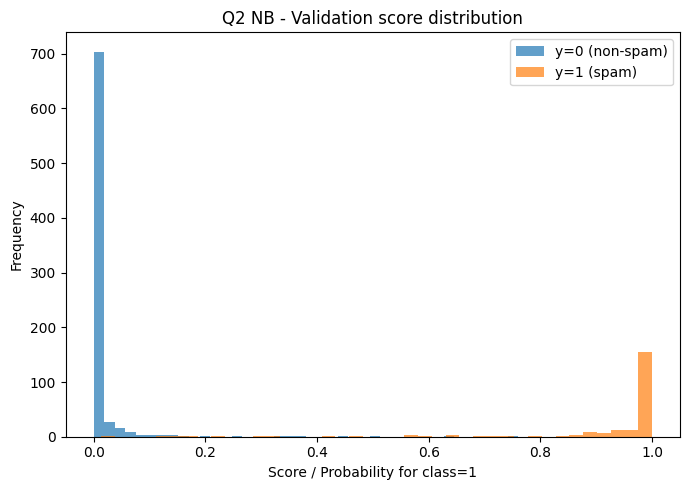

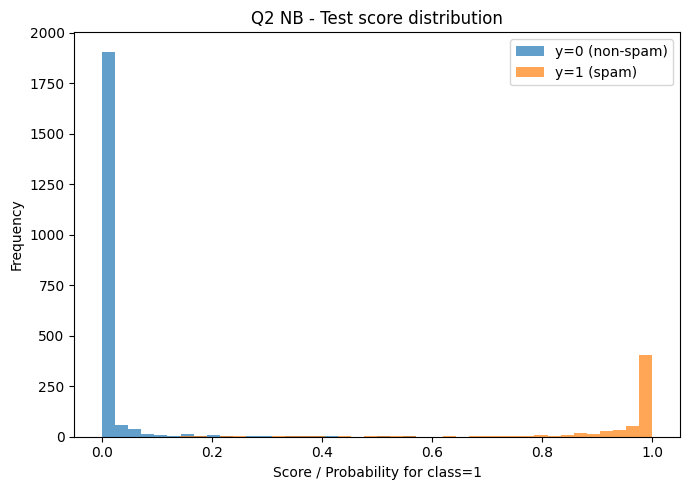

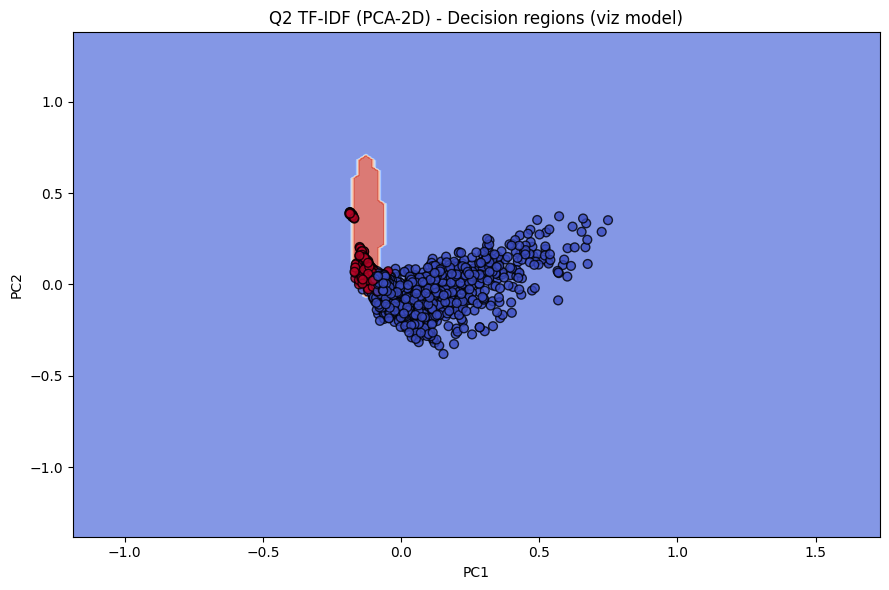

In [20]:
plot_pr_curve(y_val,  q2_va_score, "Q2 NB - Validation PR curve")
plot_pr_curve(y_test, q2_te_score, "Q2 NB - Test PR curve")

plot_score_hist(y_val,  q2_va_score, "Q2 NB - Validation score distribution")
plot_score_hist(y_test, q2_te_score, "Q2 NB - Test score distribution")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

pca2 = PCA(n_components=2, random_state=42)
X2_train = pca2.fit_transform(Xtr_tfidf.toarray())
X2_val   = pca2.transform(Xva_tfidf.toarray())

viz_nb = GaussianNB()
viz_nb.fit(X2_train, y_train)

def plot_decision_boundary_2d(X2, y, clf, title):
    h = 0.02
    x_min, x_max = X2[:,0].min()-1, X2[:,0].max()+1
    y_min, y_max = X2[:,1].min()-1, X2[:,1].max()+1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()]).reshape(xx.shape)

    plt.figure(figsize=(9,6))
    plt.contourf(xx, yy, Z, alpha=0.7, cmap=plt.cm.coolwarm)
    plt.scatter(X2[:,0], X2[:,1], c=y, edgecolors="k", s=40, cmap=plt.cm.coolwarm, alpha=0.8)
    plt.title(title)
    plt.xlabel("PC1")
    plt.ylabel("PC2")
    plt.tight_layout()
    plt.show()

plot_decision_boundary_2d(X2_train, y_train, viz_nb, "Q2 TF-IDF (PCA-2D) - Decision regions (viz model)")

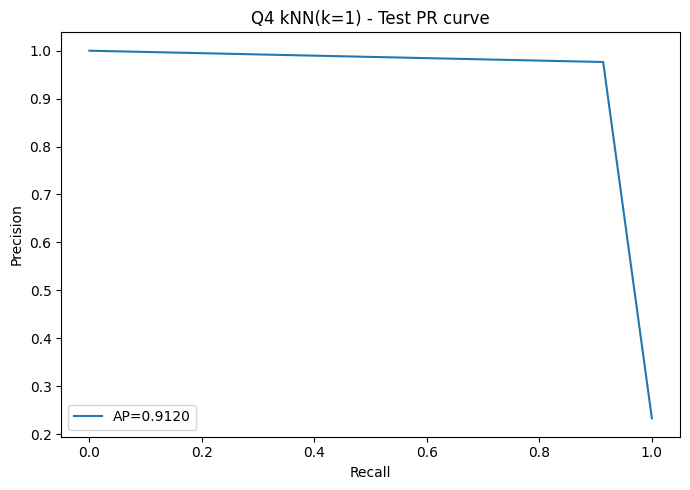

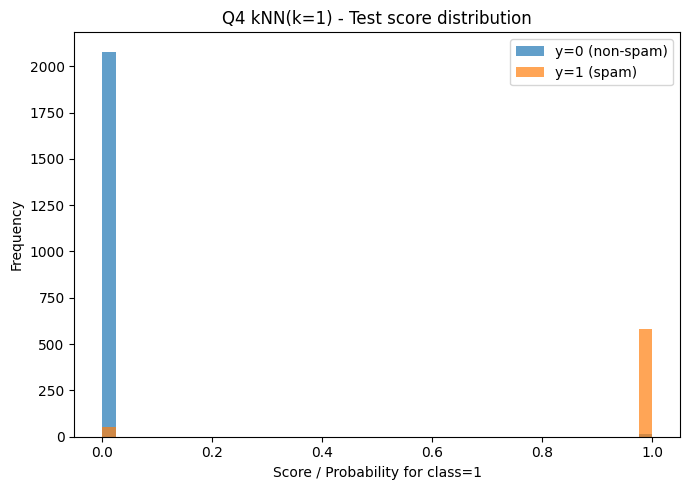

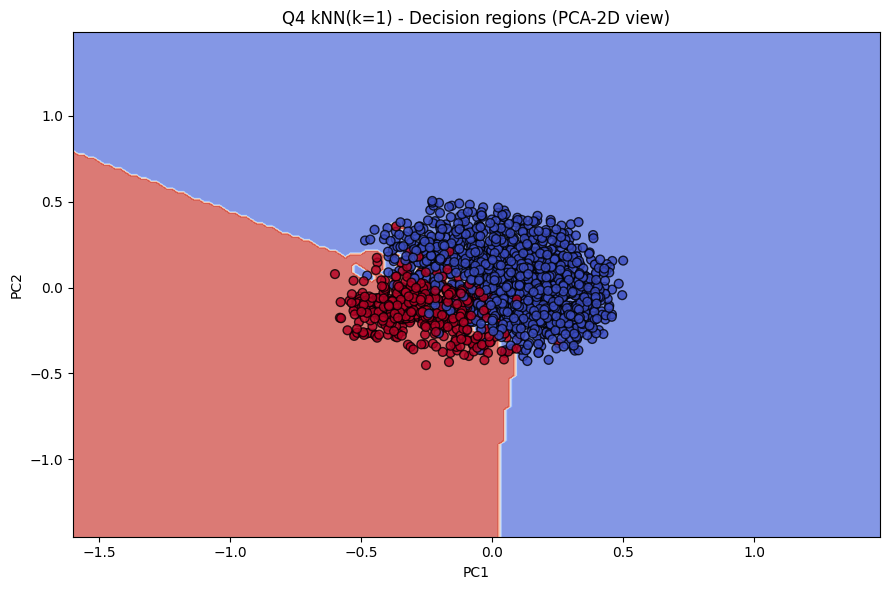

In [21]:
plot_pr_curve(y_test, q4_te_score, f"Q4 kNN(k={best_k}) - Test PR curve")
plot_score_hist(y_test, q4_te_score, f"Q4 kNN(k={best_k}) - Test score distribution")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier

pca2 = PCA(n_components=2, random_state=42)
E2_train = pca2.fit_transform(E_train)

knn2d = KNeighborsClassifier(n_neighbors=best_k)
knn2d.fit(E2_train, y_train)

plot_decision_boundary_2d(E2_train, y_train, knn2d, f"Q4 kNN(k={best_k}) - Decision regions (PCA-2D view)")

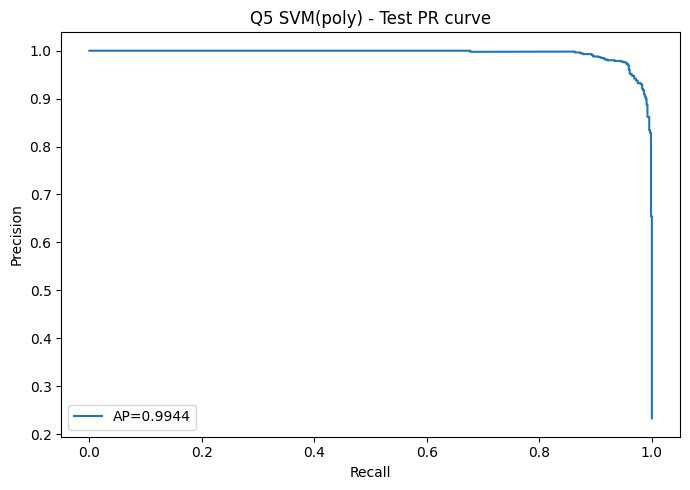

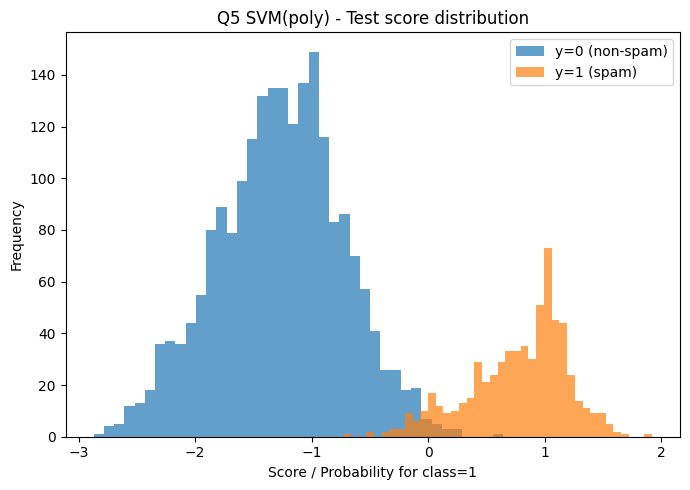

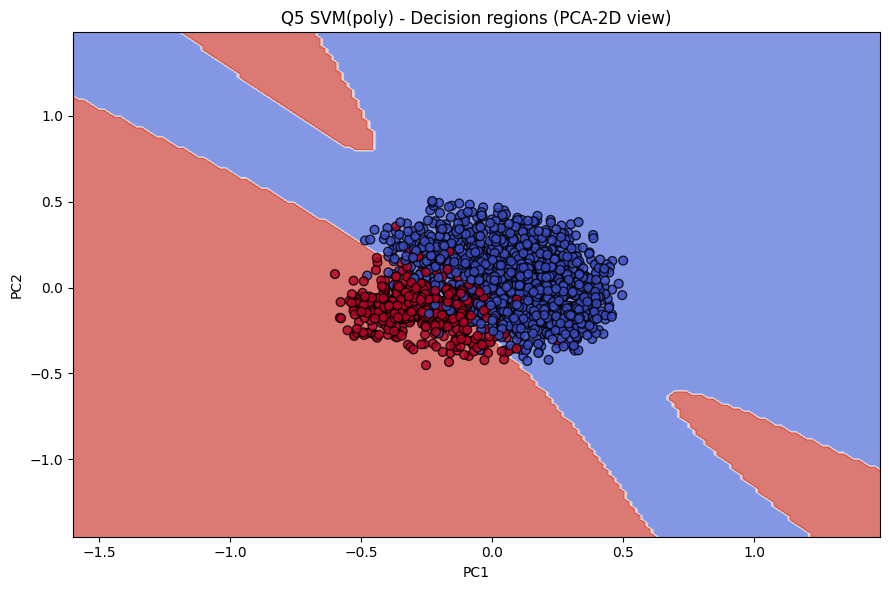

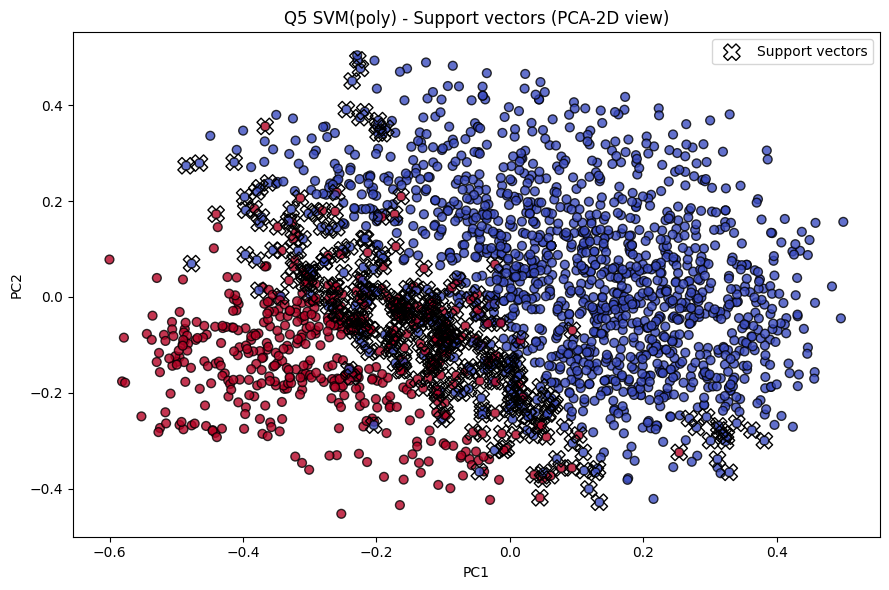

In [22]:
plot_pr_curve(y_test, q5_te_score, f"Q5 SVM({best_kernel}) - Test PR curve")
plot_score_hist(y_test, q5_te_score, f"Q5 SVM({best_kernel}) - Test score distribution")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

pca2 = PCA(n_components=2, random_state=42)
E2_train = pca2.fit_transform(E_train)

svm2d = SVC(kernel=best_kernel, C=1.0, gamma="scale")
svm2d.fit(E2_train, y_train)

# Decision regions
plot_decision_boundary_2d(E2_train, y_train, svm2d, f"Q5 SVM({best_kernel}) - Decision regions (PCA-2D view)")

sv = svm2d.support_vectors_
plt.figure(figsize=(9,6))
plt.scatter(E2_train[:,0], E2_train[:,1], c=y_train, edgecolors="k", s=40, cmap=plt.cm.coolwarm, alpha=0.8)
plt.scatter(sv[:,0], sv[:,1], facecolors="none", edgecolors="black", s=140, marker="X", label="Support vectors")
plt.title(f"Q5 SVM({best_kernel}) - Support vectors (PCA-2D view)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.legend()
plt.tight_layout()
plt.show()

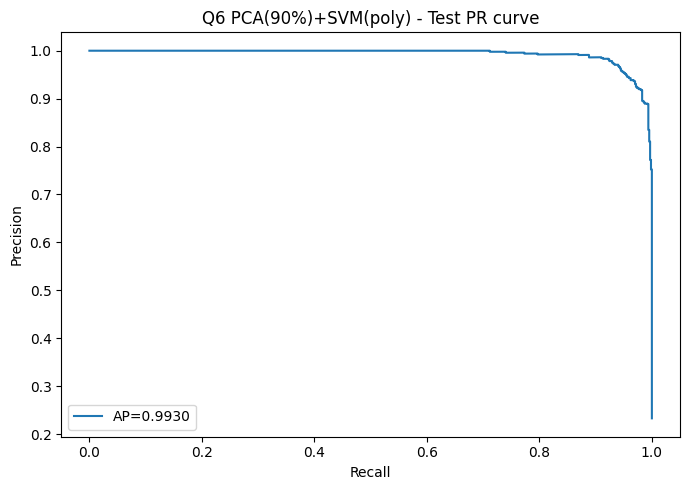

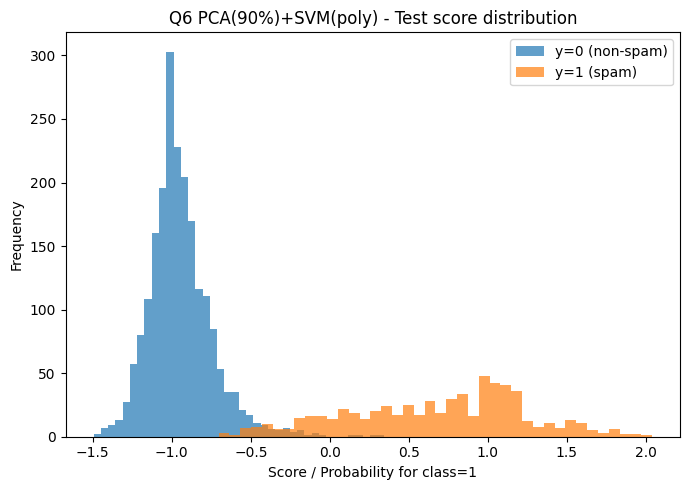

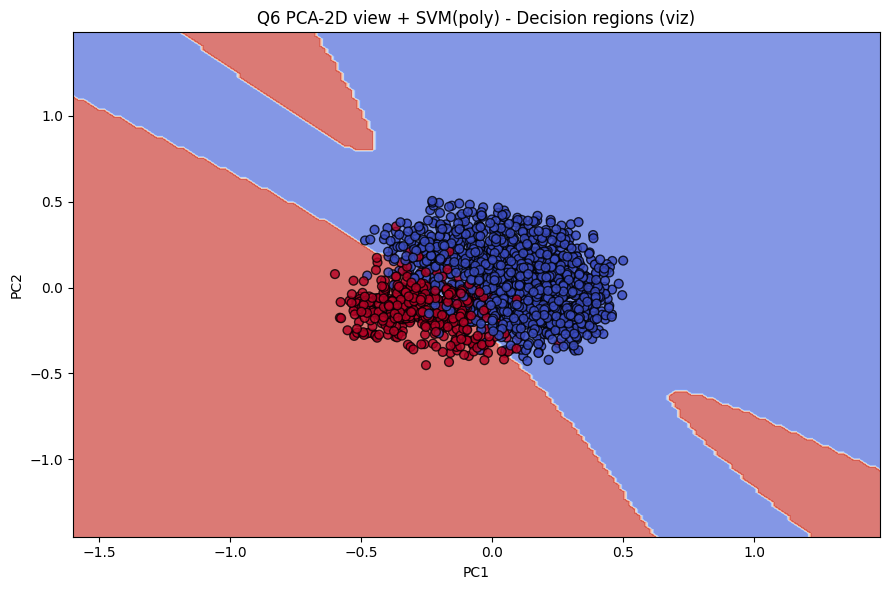

In [23]:
plot_pr_curve(y_test, q6_te_score, f"Q6 PCA({int(best_var*100)}%)+SVM({best_kernel}) - Test PR curve")
plot_score_hist(y_test, q6_te_score, f"Q6 PCA({int(best_var*100)}%)+SVM({best_kernel}) - Test score distribution")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.svm import SVC

pca2 = PCA(n_components=2, random_state=42)
E2_train = pca2.fit_transform(E_train)

svm2d = SVC(kernel=best_kernel, C=1.0, gamma="scale")
svm2d.fit(E2_train, y_train)

plot_decision_boundary_2d(E2_train, y_train, svm2d, f"Q6 PCA-2D view + SVM({best_kernel}) - Decision regions (viz)")

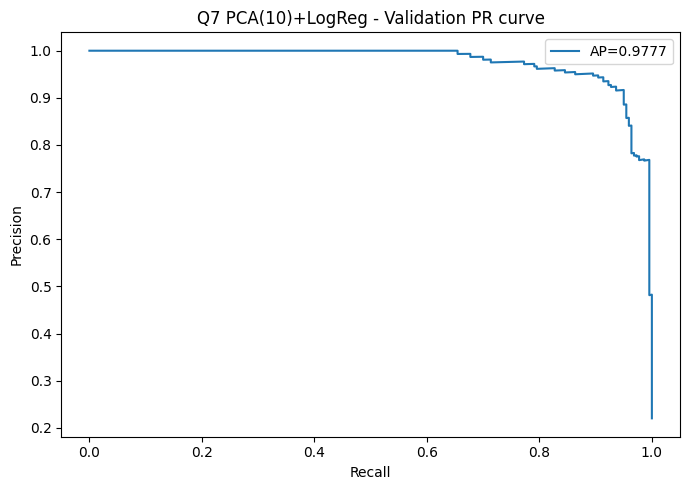

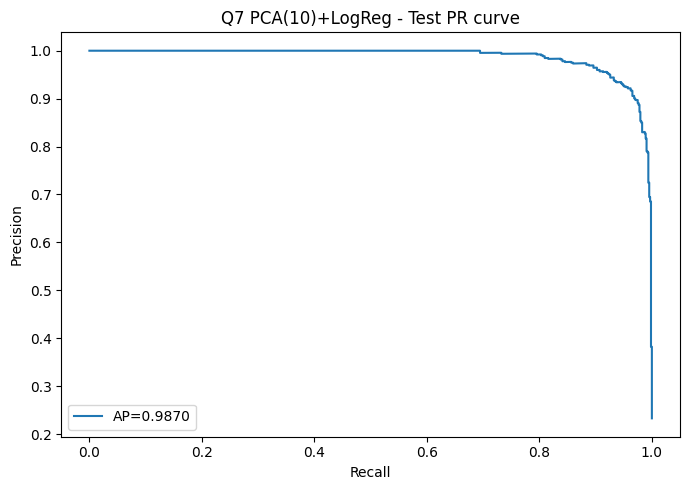

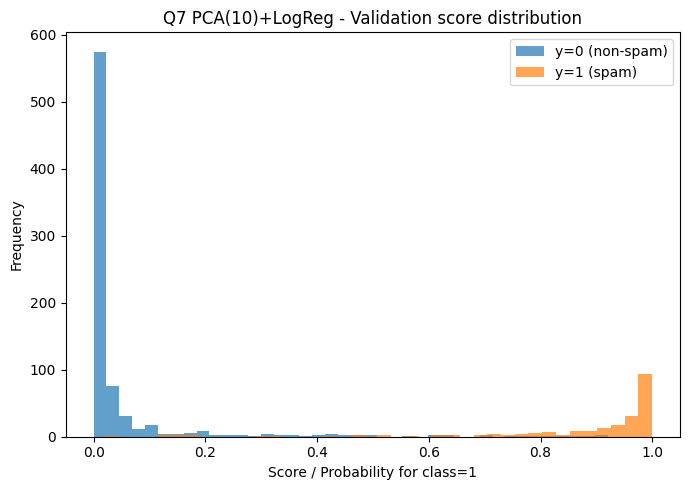

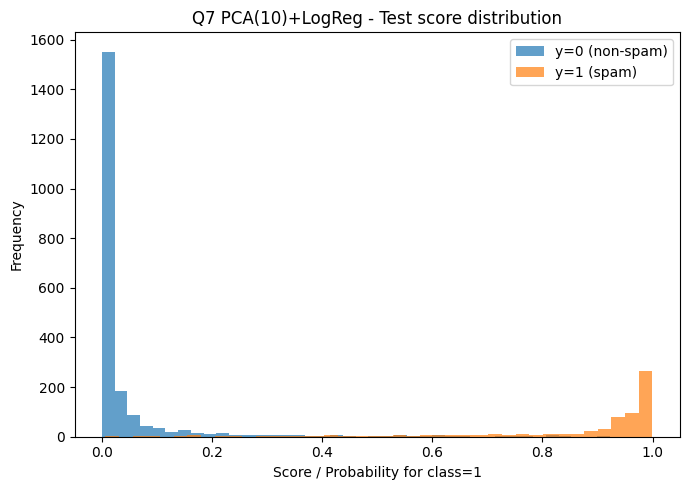

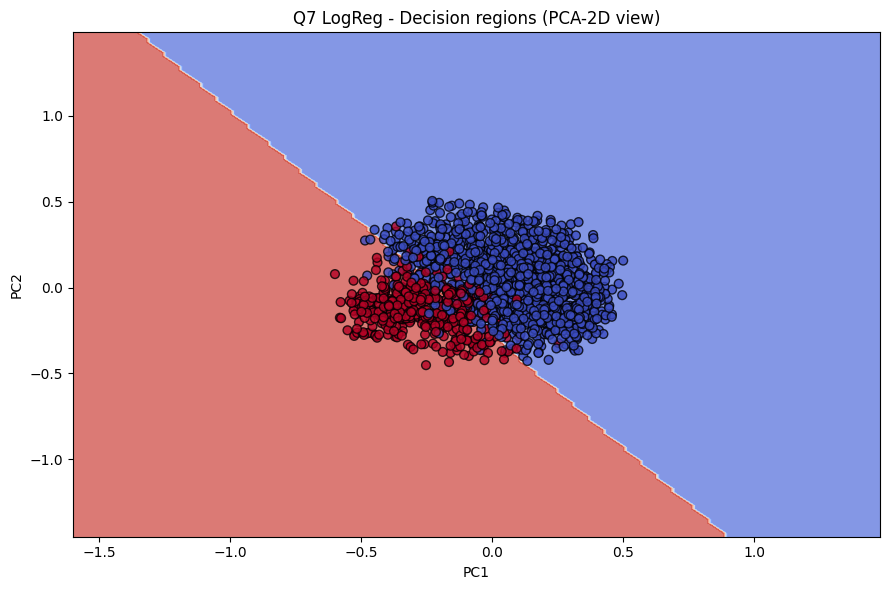

In [24]:
plot_pr_curve(y_val,  q7_va_score, "Q7 PCA(10)+LogReg - Validation PR curve")
plot_pr_curve(y_test, q7_te_score, "Q7 PCA(10)+LogReg - Test PR curve")

plot_score_hist(y_val,  q7_va_score, "Q7 PCA(10)+LogReg - Validation score distribution")
plot_score_hist(y_test, q7_te_score, "Q7 PCA(10)+LogReg - Test score distribution")

import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.linear_model import LogisticRegression

pca2 = PCA(n_components=2, random_state=42)
E2_train = pca2.fit_transform(E_train)

lr2d = LogisticRegression(max_iter=3000)
lr2d.fit(E2_train, y_train)

plot_decision_boundary_2d(E2_train, y_train, lr2d, "Q7 LogReg - Decision regions (PCA-2D view)")